# LieGG for the rotation-MNIST minimal example 

In [2]:
import sys
import numpy as np
import torch
import torch.nn as nn
import random
from copy import deepcopy
import scipy.linalg as SL

# symmetries
from src.models import MLP
from src.liegg import polarization_matrix_2, symmetry_metrics
from src.datasets import RotoMNIST
from src.utils import L2_normed_net, count_parameters

import matplotlib.pyplot as plt
%matplotlib inline

### Train/Test utils:

In [3]:
def test(model, data, device='cuda'):
    
    device = torch.device(device)
    model.to(device)
    model.eval()
    
    dataloader_test = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    
    acc = 0
    for (inputs, labels) in dataloader_test:
        
        inputs_ravel = inputs.reshape(1, -1).float().to(device)
        pred = model(inputs_ravel).argmax().item()
        true = labels.item()
        acc += int(pred == true)
        
    mean_acc = acc / len(dataloader_test)
    return mean_acc

def train_val(model, optimizer, data_train, data_val, n_epochs = 100, device='cuda', seed=2022):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    device = torch.device(device)
    model.to(device)

    # data    
    batch_size = 512
    dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=False)
    
    # loss
    criterion = nn.CrossEntropyLoss()

    losses, val_accs = [], []
    best_score, best_model = -1*float('inf'), None
    for epoch in range(n_epochs):

        running_loss = 0
        model.train(True)
        model.to(device)

        for i, (inputs, labels) in enumerate(dataloader_train):
            
            optimizer.zero_grad()

            inputs_ravel = inputs.reshape(inputs.shape[0], -1).float().to(device)
            outputs = model(inputs_ravel)
            loss = criterion(outputs, labels.long().to(device))
            
            loss.backward()
            optimizer.step()

            # logging
            running_loss += loss
            if i % 10 == 0:
                losses += [loss.item()]
                running_loss = 0.0
                
        # validate
        if not data_val is None:
                        
            with torch.no_grad():
                val_acc = test(model, data_val, device)
                val_accs += [val_acc]
                
                if val_acc > best_score:
                    best_score = val_acc
                    best_model = deepcopy(model)

            sys.stdout.write('({}) val_acc:{}, loss:{}\r'.format(epoch+1, 
                                                               np.round(val_acc, 3), 
                                                  np.round(running_loss.item()/10, 3)))
            
    return best_model, losses, val_accs

### Define data and model:

In [4]:
data_train = RotoMNIST(data_path='/home/ferumchrome/data/rotMNIST/', split='train360', blur=1.5)
data_val = RotoMNIST(data_path='/home/ferumchrome/data/rotMNIST/', split='val360', blur=1.5)

In [5]:
net = MLP(in_dim=28*28, out_dim=10, num_nonlins=5, ch=128)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

_________________

### LieGG:

In [6]:
# train the model
best_model, losses, val_accs = train_val(net, opt, data_train, data_val, n_epochs = 200)

In [7]:
# compute the network polarization matrix
data_X,_ = data_train.get_vectorized()
data_X = torch.FloatTensor(data_X)

norm_logits_net = L2_normed_net(best_model)
E = polarization_matrix_2(norm_logits_net.cpu(), data_X)

In [8]:
# compute symmetry variance and bias
singular_values, symmetry_biases, generators = symmetry_metrics(E)

print('Symmetry variance: ', singular_values[-1].item())
print('min Symmetry bias: ', symmetry_biases[-1].item())

Symmetry variance:  0.0008051968761719763
min Symmetry bias:  0.021394861862063408


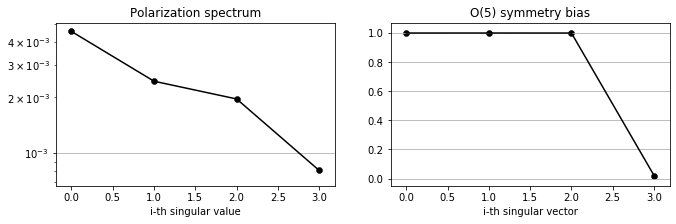

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))

ax[0].grid(axis='y')
ax[0].plot(singular_values.data, color='black')
ax[0].scatter(torch.arange(singular_values.shape[0]), singular_values.data, color='black', linewidths=.5)
ax[0].set_yscale('log')
ax[0].set_title('Polarization spectrum')
ax[0].set_xlabel('i-th singular value')

ax[1].grid(axis='y')
ax[1].plot(symmetry_biases.data, color='black')
ax[1].scatter(torch.arange(symmetry_biases.shape[0]), symmetry_biases.data, color='black', linewidths=.5)
ax[1].set_title('O(5) symmetry bias')
ax[1].set_xlabel('i-th singular vector')
plt.show();

### Visualize learned generator:

In [10]:
def rotate_resample(img, G):
    
    # img: (1, 1, 28, 28)
    # G: (2,2)
    
    # proc input image
    img_in = img.cpu().data
    
    # wrap to affine transform
    R = torch.zeros((2,3))
    R[:2,:2] = G.cpu().data
    
    # sample grid
    grid = nn.functional.affine_grid(R.unsqueeze(0), img_in.size())
    
    # resample img
    img_out = nn.functional.grid_sample(img_in, grid)
    
    return img_out[0,0]

In [11]:
# Lie algebra to Lie group
H = generators[-1]

rad = np.deg2rad(45)
G = torch.matrix_exp(H*rad)

In [12]:
# sample image from the dataset
img = data_X[0]

# rotate img with the learned generator
img_r = rotate_resample(img.reshape(1,1,*data_X[0].shape), G);

/home/ferumchrome/anaconda3/envs/qsym/lib/python3.6/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ferumchrome/anaconda3/envs/qsym/lib/python3.6/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


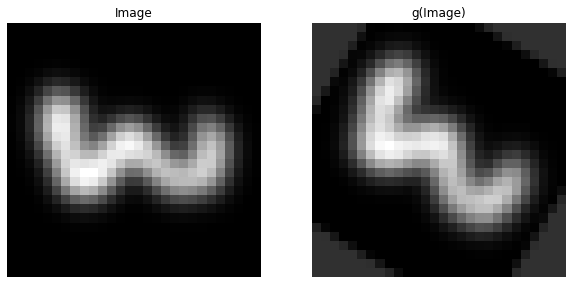

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img, cmap='gray', aspect='equal')
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(img_r, cmap='gray', aspect='equal')
ax[1].set_title('g(Image)')
ax[1].axis('off');